Part 1: ETL Process for Branch, Customer, and Credit Data

In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [5]:
spark = SparkSession\
    .builder\
    .config("spark.jars", "/Users/nahidrahman/opt/miniconda3/lib/python3.9/site-packages/pyspark/jars/mysql-connector-j-8.0.31.jar")\
    .appName("creditcard")\
    .getOrCreate()

Loading json files for the branch, customer, and credit data and creating Pyspark dataframes

In [7]:
df_branch = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_branch.json")

df_custmer = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_custmer.json")

df_credit = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_credit.json")

Creating the database

In [ ]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="****",
  password="****"
)
mycursor = mydb.cursor()
mycursor.execute("CREATE DATABASE creditcard_capstone")

Write the customer, branch, and credit dataframe into the database

In [8]:
df_custmer.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTMER") \
  .option("user", "****") \
  .option("password", "****") \
  .mode("overwrite")\
  .option("driver", 'com.mysql.jdbc.Driver')\
  .save()
"""
connects to the mysql database with:
local host as 3306
creditcard_capstone as database name
CDW_SAPP_CUSTOMER as table name
"""

In [ ]:
df_branch.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
  .option("user", "****") \
  .option("password", "****") \
  .mode("overwrite")\
  .option("driver", 'com.mysql.jdbc.Driver')\
  .save()

Adding a full date column to the credit dataframe before writing it into the database

In [8]:
#converts DAY, MONTH, and YEAR into a TIMEID (YYYYMMDD)
from pyspark.sql.functions import concat_ws, lpad

# creates a new column called "TIMEID" by concatenating YEAR, MONTH, and DAY columns
df_credit = df_credit.withColumn("TIMEID", concat_ws("", "YEAR", lpad("MONTH", 2, "0"), lpad("DAY", 2, "0")))

In [9]:
df_credit.show(1)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|  TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|20180214|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
only showing top 1 row



In [ ]:
df_credit.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT") \
          .option("user", "*****") \
            .option("password", "*****") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

PART 2: Data Analysis and Visualization

Find and plot transactions showing which transaction type occurs most often

In [31]:
import matplotlib.pyplot as plt

#makes a list of all the unqiue transactions 
list_of_transactions = df_credit.select('transaction_type').distinct().rdd.map(lambda r: r[0]).collect()

#finds the total number of rows of credit dataframe
total_transactions = df_credit.count()

#finds the percentage rate of each transaction type
perc_education = (df_credit.filter(df_credit['transaction_type'] == 'Education').count()) / total_transactions
perc_gas = (df_credit.filter(df_credit['transaction_type'] == 'Gas').count()) / total_transactions
perc_entertainment = (df_credit.filter(df_credit['transaction_type'] == 'Entertainment').count()) / total_transactions
perc_bills = (df_credit.filter(df_credit['transaction_type'] == 'Bills').count()) / total_transactions
perc_grocery = (df_credit.filter(df_credit['transaction_type'] == 'Grocery').count()) / total_transactions
perc_test = (df_credit.filter(df_credit['transaction_type'] == 'Test').count()) / total_transactions
perc_healthcare = (df_credit.filter(df_credit['transaction_type'] == 'Healthcare').count()) / total_transactions

#stores it into a list
rate_of_transactions = [perc_education, perc_entertainment, perc_healthcare, perc_grocery, perc_test, perc_gas, perc_bills]


Text(0.5, 1.0, 'Percentage Each Transaction Type were Made')

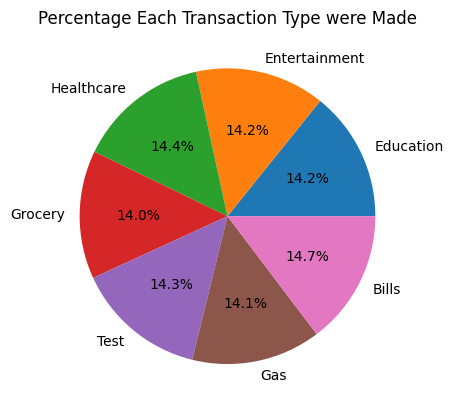

In [32]:
plt.pie(rate_of_transactions, labels =list_of_transactions, autopct='%.1f%%')
plt.title('Percentage Each Transaction Type were Made')


Find and plot states, showing which stte has the highest number of customers

In [38]:
import pandas as pd
from pyspark.sql.functions import count

#creates a dataframe showing which states has the most customers 
df_custmer.groupBy("CUST_STATE").count().sort('count', ascending = False).show()

+----------+-----+
|CUST_STATE|count|
+----------+-----+
|        NY|   96|
|        GA|   73|
|        PA|   72|
|        FL|   64|
|        IL|   58|
|        NJ|   53|
|        MD|   50|
|        CA|   45|
|        MI|   44|
|        OH|   44|
|        VA|   39|
|        NC|   37|
|        TX|   33|
|        MA|   33|
|        SC|   30|
|        WI|   29|
|        MN|   28|
|        MS|   24|
|        IA|   21|
|        KY|   17|
+----------+-----+
only showing top 20 rows



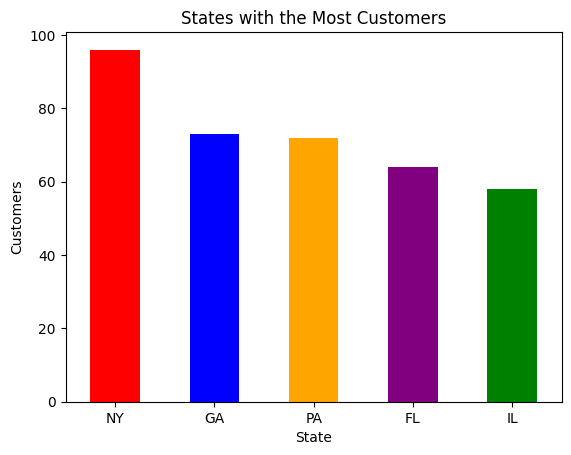

In [41]:
#converts the pyspark dataframe into a pandas dataframe
states = (df_custmer.groupBy("CUST_STATE").count().sort('count', ascending = False)).toPandas()

#filters the dataframe to show only the top 5 values 
top5_states = states.loc[states['count'] >53] 

c = ['red', 'blue', 'orange', 'purple', 'green']
states_plot = top5_states.plot.bar(x='CUST_STATE', y='count', title= 'States with the Most Customers', rot=0, color= c, legend=None, xlabel='State', ylabel='Customers')

Find and plot the sum of all transactions for each customer and which customer has the highest transaction amount (hint: use CUST_SSN)

In [13]:
df_branch.createTempView("branch")
df_credit.createTempView("credit")
df_custmer.createTempView("customer")

In [49]:
#uses subquery to get the sum of the top 10 customers 
spark.sql("SELECT sum(total_amount) \
          FROM (SELECT cust_ssn, ROUND(sum(transaction_value),2) as total_amount \
                FROM credit \
                GROUP BY cust_ssn \
                ORDER by 2 desc \
                LIMIT 10)") \
        .show()

+-----------------+
|sum(total_amount)|
+-----------------+
|         53184.55|
+-----------------+



In [50]:
print("Customer with the highest transaction amount")
spark.sql("SELECT cust_ssn, ROUND(sum(transaction_value),2) as total_amount \
          FROM credit \
          GROUP BY cust_ssn \
          ORDER by 2 desc \
          LIMIT 1") \
        .show()

Customer with the highest transaction amount
+---------+------------+
| cust_ssn|total_amount|
+---------+------------+
|123451125|     5633.07|
+---------+------------+



In [44]:
df_cust_val = spark.sql("SELECT CUST_SSN, SUM(TRANSACTION_VALUE) AS TOTAL_VALUE \
                        FROM credit \
                        GROUP BY CUST_SSN \
                        ORDER BY TOTAL_VALUE DESC") 

In [53]:
df_cust_val = df_cust_val.toPandas()

In [56]:
print("Customers with the Highest Transaction Amounts")
df_cust_val.head(10)

Customers with the Highest Transaction Amounts


,CUST_SSN,TOTAL_VALUE
0,123451125,5633.07
1,123452783,5548.14
2,123453486,5476.08
3,123458668,5314.97
4,123456678,5261.03
5,123452026,5241.18
6,123452518,5223.96
7,123454933,5203.08
8,123457547,5149.75
9,123452085,5133.29


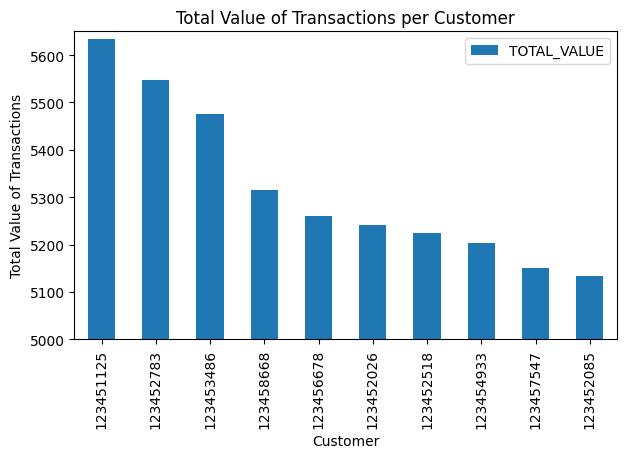

In [57]:
df_cust_val.head(10).plot(kind='bar', x='CUST_SSN', y='TOTAL_VALUE', figsize=(7, 4))
plt.title('Total Value of Transactions per Customer')
plt.ylabel('Total Value of Transactions')
plt.xlabel('Customer')
plt.ylim(5000,5650)
plt.show()

Part 3: Reading and Writing Loan API data

In [58]:
import requests
import json

api_url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(api_url)

In [59]:
response.status_code

200

In [62]:
cdw_sapp_loan = response.json()
df_loan = spark.createDataFrame(cdw_sapp_loan)

In [13]:
#creates a json file for the loan data 
with open('cdw_sapp_loan.json', 'w') as out_file:
     json.dump(cdw_sapp_loan, out_file) 

In [18]:
df_loan.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [ ]:
#writes the loan dataframe into the mysql database
df_loan.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_LOAN") \
          .option("user", "root") \
            .option("password", "password") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

Part 4: Data Analysis and Visualization Using Loan Data

In [63]:
df_loan.createTempView('loan')


Finding and plotting the percentage of applications approved for self-employed applicants.

In [64]:
#queries dataframe to get the app status for all people who are self_employed, then converts it to a pandas dataframe
status_self_employed = (spark.sql("SELECT Application_status \
                                  FROM loan \
                                  WHERE self_employed = 'Yes'"))\
                                    .toPandas()

#get the amount of Y and N for the application status
status_count = status_self_employed.value_counts()

#converts the counts into percentages using map function
percentage_status = status_count.map( lambda x: x/70)

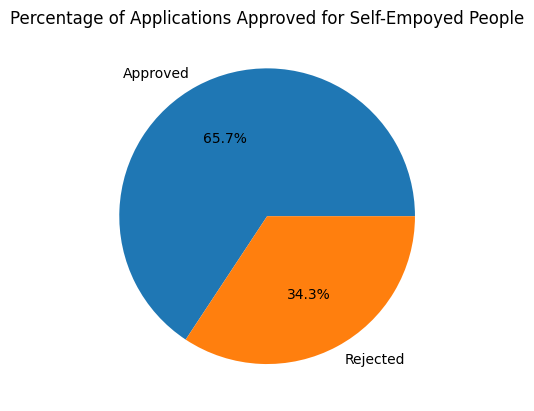

In [66]:
percentage_status.plot(kind= 'pie', title= 'Percentage of Applications Approved for Self-Empoyed People', autopct = '%.1f%%', labels= ('Approved', 'Rejected'))
plt.show()

Finding the percentage of rejection for married male applicants 

In [68]:
status_married_male = (spark.sql("Select application_status \
                                 From loan \
                                 Where (Gender = 'Male' and Married = 'Yes')"))\
                                    .toPandas()

count_status = status_married_male.value_counts()
percentage_status_married_male = count_status.map( lambda x: x/306)

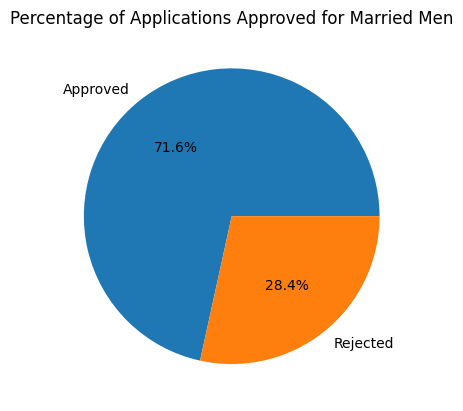

In [69]:
percentage_status_married_male.plot(kind= 'pie', title= 'Percentage of Applications Approved for Married Men', autopct = '%.1f%%', labels= ('Approved', 'Rejected'))
plt.show()

Find and plot the top three months with the largest transaction data.

In [70]:
#queries the top 3 months with most transactions from credit df 
top3_months = (spark.sql("SELECT month, count(*) as transactions \
                         FROM credit \
                         GROUP BY month \
                         HAVING transactions > 3940 \
                         ORDER BY transactions desc"))\
                            .toPandas()

<Axes: title={'center': 'Months with Most Transactions'}, xlabel='Month', ylabel='Transactions'>

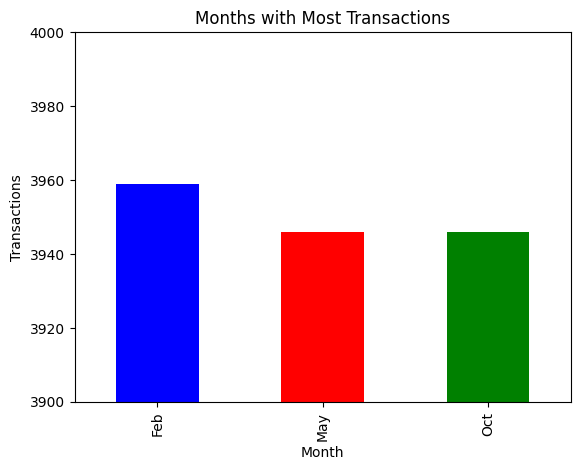

In [71]:
top3_months.replace(2, 'Feb', inplace= True)
top3_months.replace(5, 'May', inplace= True)
top3_months.replace(10, 'Oct', inplace= True)

top3_months.plot(kind='bar', x='month', y='transactions', ylim=(3900, 4000), title= 'Months with Most Transactions', color=['blue', 'red', 'green'], xlabel='Month', ylabel='Transactions', legend=None)

Find and plot which branch processed the highest total dollar value of healthcare transactions.

<Axes: title={'center': 'Branch with Highest Healthcare Transaction Value'}, xlabel='BRANCH_CITY'>

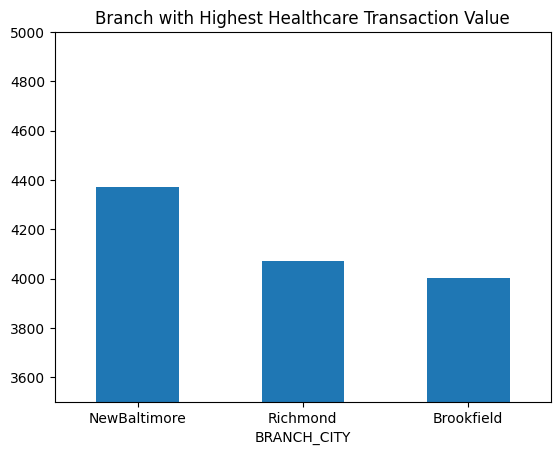

In [72]:
healthcare_total_amount = ((spark.sql("SELECT BRANCH_CITY, sum(transaction_value) total_transaction_amount \
                                        FROM credit ct INNER JOIN branch bt on ct.branch_code = bt.branch_code \
                                        WHERE transaction_type = 'Healthcare' \
                                        GROUP BY BRANCH_CITY \
                                        HAVING total_transaction_amount > 4000 \
                                        ORDER BY 2 desc ")))\
                                            .toPandas()

healthcare_total_amount.plot(kind = 'bar', x='BRANCH_CITY', y='total_transaction_amount', title= 'Branch with Highest Healthcare Transaction Value', ylim=(3500, 5000), rot=0, legend=None)

In [ ]:
spark.stop